## German Football League Data Exploratory Analysis

### German football league match dataset and team's metadata information is being used to perform data exploratory analysis and answer the following business questions. 

#### Question #1 Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000-2016?
#### Question #2 Which teams have been relegated between 2000-2016?
#### Question #3 Which season of bundesliga was the most competitive between 2000-2016?
#### Question #4 What's the best month to watch Bundesliga?
#### Question #5 Does stadium capacity have impact on number of home win games? 
#### Question #6 Does domestic/foreign players count have any impact on total team points for Hannover?
#### Question #7 What is the market trend of Bundesliga Division 1 and 2 between 2005 and 2016? 

### Importing Libraries and Initiating SparkSession

In [1]:
# Importing necessary PySpark library
import pyspark
from pyspark.sql import SparkSession

In [4]:
# Creating a SparkSession
spark = SparkSession.builder.appName("football").getOrCreate()

23/04/10 18:00:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Importing the dataset

In [6]:
# Reading the football matches CSV file
df_matches = spark.read.csv('matches.csv',header=True,inferSchema=True)

In [7]:
# Printing the dataset schema
df_matches.printSchema()

root
 |-- Match_ID: integer (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FTHG: integer (nullable = true)
 |-- FTAG: integer (nullable = true)
 |-- FTR: string (nullable = true)



In [9]:
# Viewing the dataset as pandas due to better formatting 
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


### Dataset Manipulation

In [33]:
# Converting the name of last 3 columns to their english abbreviation
df_matches2  = df \
    .withColumnRenamed("FTHG","HomeTeamGoals") \
    .withColumnRenamed("FTAG","AwayTeamGoals") \
    .withColumnRenamed("FTR","GameResult") \

df_matches2.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,GameResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [42]:
# Performing casting on some numeric features that are currently in string format
from pyspark.sql.types import IntegerType,DateType

df_matches2 = df_matches2 \
.withColumn('HomeTeamGoals', col('HomeTeamGoals').cast(IntegerType())) \
.withColumn('AwayTeamGoals', col('AwayTeamGoals').cast(IntegerType())) \
.withColumn('Date', col('Date').cast(DateType()))

df_matches2.printSchema()

root
 |-- Match_ID: integer (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- HomeTeamGoals: integer (nullable = true)
 |-- AwayTeamGoals: integer (nullable = true)
 |-- GameResult: string (nullable = true)



In [43]:
# One-hot-encoding on the categorical GameResult feature
from pyspark.sql.functions import when, col

df_matches2 = df_matches2 \
    .withColumn('HomeTeamWin', when(col('GameResult') == 'H', 1).otherwise(0)) \
    .withColumn('AwayTeamWin', when(col('GameResult') == 'A', 1).otherwise(0)) \
    .withColumn('GameTie', when(col('GameResult') == 'D', 1).otherwise(0))

df_matches2.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,GameResult,HomeTeamWin,AwayTeamWin,GameTie
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H,1,0,0
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A,0,1,0
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D,0,0,1
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H,1,0,0
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A,0,1,0


In [45]:
# Ensuring the new encoded fields are in integer format for future manipulation
df_matches2.printSchema()

root
 |-- Match_ID: integer (nullable = true)
 |-- Div: string (nullable = true)
 |-- Season: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- HomeTeamGoals: integer (nullable = true)
 |-- AwayTeamGoals: integer (nullable = true)
 |-- GameResult: string (nullable = true)
 |-- HomeTeamWin: integer (nullable = false)
 |-- AwayTeamWin: integer (nullable = false)
 |-- GameTie: integer (nullable = false)



In [123]:
# As the dataset contains other leagues, filtering Bundesliga division 1 games and years below 2016

bundesliga = df_matches2.filter((col('Div') == 'D1') & (col('Season') <= 2016))

bundesliga.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,GameResult,HomeTeamWin,AwayTeamWin,GameTie
0,21,D1,2009,2010-02-06,Bochum,Leverkusen,1,1,D,0,0,1
1,22,D1,2009,2009-11-22,Bayern Munich,Leverkusen,1,1,D,0,0,1
2,23,D1,2009,2010-05-08,M'gladbach,Leverkusen,1,1,D,0,0,1
3,24,D1,2009,2009-08-08,Mainz,Leverkusen,2,2,D,0,0,1
4,25,D1,2009,2009-10-17,Hamburg,Leverkusen,0,0,D,0,0,1


In [124]:
# The current dataset contains match level stats for both home and away teams in each row
# One simple way to aggregate the performance metrics (goals, wins, etc.) for each team (regardless Home or Away)
# is to divide the original dataset into 2 subsets home and away team game performance
# Below is creating home team game performance table in bundesliga

from pyspark.sql.functions import sum as summation

bundesliga_home = bundesliga.groupBy(['Season', 'HomeTeam']) \
    .agg(summation('HomeTeamGoals').alias('HomeTotalGoalScored'), 
        summation('AwayTeamGoals').alias('HomeTotalGoalConceded'), 
        summation('HomeTeamWin').alias('HomeMatchesWon'),
        summation('AwayTeamWin').alias('HomeMatchesLost'),
        summation('GameTie').alias('HomeMatchesTie'),
        summation(bundesliga['HomeTeamWin'] + bundesliga['AwayTeamWin'] + bundesliga['GameTie']).alias('HomeMatchesPlayed'))

bundesliga_home = bundesliga_home.withColumnRenamed('HomeTeam', 'Team')

bundesliga_home.limit(5).toPandas()

,Season,Team,HomeTotalGoalScored,HomeTotalGoalConceded,HomeMatchesWon,HomeMatchesLost,HomeMatchesTie,HomeMatchesPlayed
0,2005,Bayern Munich,42,14,14,1,2,17
1,1999,Munich 1860,36,20,11,3,3,17
2,2008,M'gladbach,23,27,5,8,4,17
3,2014,Freiburg,21,22,5,6,6,17
4,2015,Wolfsburg,32,17,9,3,5,17


In [125]:
# Below is creating away team game performance table in bundesliga

bundesliga_away = bundesliga.groupBy(['Season', 'AwayTeam']) \
    .agg(summation('AwayTeamGoals').alias('AwayTotalGoalScored'), 
        summation('HomeTeamGoals').alias('AwayTotalGoalConceded'), 
        summation('AwayTeamWin').alias('AwayMatchesWon'),
        summation('HomeTeamWin').alias('AwayMatchesLost'),
        summation('GameTie').alias('AwayMatchesTie'),
        summation(bundesliga['HomeTeamWin'] + bundesliga['AwayTeamWin'] + bundesliga['GameTie']).alias('AwayMatchesPlayed'))

bundesliga_away = bundesliga_away.withColumnRenamed('AwayTeam', 'Team')

bundesliga_away.limit(5).toPandas()

,Season,Team,AwayTotalGoalScored,AwayTotalGoalConceded,AwayMatchesWon,AwayMatchesLost,AwayMatchesTie,AwayMatchesPlayed
0,2005,Bayern Munich,25,18,8,2,7,17
1,1999,Munich 1860,19,28,3,6,8,17
2,2008,M'gladbach,16,35,3,11,3,17
3,2014,Freiburg,15,25,2,8,7,17
4,2015,Wolfsburg,15,32,3,10,4,17


In [126]:
# Now both home and away tables contains game stats per 1 team (home and away performance seperate)
# Final step is joining these two tables so that game stats for each team can be in one single table
# Inner joining home and away tables by using season and team as join keys

bundesliga_matches = bundesliga_home.join(bundesliga_away, ['Season', 'Team'], 'inner')

bundesliga_matches.limit(5).toPandas()

,Season,Team,HomeTotalGoalScored,HomeTotalGoalConceded,HomeMatchesWon,HomeMatchesLost,HomeMatchesTie,HomeMatchesPlayed,AwayTotalGoalScored,AwayTotalGoalConceded,AwayMatchesWon,AwayMatchesLost,AwayMatchesTie,AwayMatchesPlayed
0,2005,Bayern Munich,42,14,14,1,2,17,25,18,8,2,7,17
1,1999,Munich 1860,36,20,11,3,3,17,19,28,3,6,8,17
2,2008,M'gladbach,23,27,5,8,4,17,16,35,3,11,3,17
3,2014,Freiburg,21,22,5,6,6,17,15,25,2,8,7,17
4,2015,Wolfsburg,32,17,9,3,5,17,15,32,3,10,4,17


In [127]:
# Introducing aggregate level columns and cleaning up the joined table by removind redundant columns

from pyspark.sql.functions import col
import pyspark.sql.functions as func

bundesliga_match_summary = bundesliga_matches\
.withColumn('Matches', bundesliga_matches['HomeMatchesPlayed'] + bundesliga_matches['AwayMatchesPlayed']) \
.withColumn('GoalScored', bundesliga_matches['HomeTotalGoalScored'] + bundesliga_matches['AwayTotalGoalScored']) \
.withColumn('GoalConceded', bundesliga_matches['HomeTotalGoalConceded'] + bundesliga_matches['AwayTotalGoalConceded']) \
.withColumn('GoalDiff', bundesliga_matches['HomeTotalGoalScored'] + bundesliga_matches['AwayTotalGoalScored'] - bundesliga_matches['HomeTotalGoalConceded'] - bundesliga_matches['AwayTotalGoalConceded']) \
.withColumn('Wins', bundesliga_matches['HomeMatchesWon'] + bundesliga_matches['AwayMatchesWon']) \
.withColumn('Loses', bundesliga_matches['HomeMatchesLost'] + bundesliga_matches['AwayMatchesLost']) \
.withColumn('Ties', bundesliga_matches['HomeMatchesTie'] + bundesliga_matches['AwayMatchesTie']) \
.withColumn('Points', 3*(bundesliga_matches['HomeMatchesWon'] + bundesliga_matches['AwayMatchesWon'])+1*(bundesliga_matches['HomeMatchesTie'] + bundesliga_matches['AwayMatchesTie'])) \
.withColumn('WinRatio%', func.round((bundesliga_matches['HomeMatchesWon'] + bundesliga_matches['AwayMatchesWon'])/(bundesliga_matches['HomeMatchesPlayed']+bundesliga_matches['AwayMatchesPlayed'])*100,2)) \
.withColumn('LoseRatio%', func.round((bundesliga_matches['HomeMatchesLost'] + bundesliga_matches['AwayMatchesLost'])/(bundesliga_matches['HomeMatchesPlayed']+bundesliga_matches['AwayMatchesPlayed'])*100,2)) \
.withColumn('TieRatio%', func.round((bundesliga_matches['HomeMatchesTie'] + bundesliga_matches['AwayMatchesTie'])/(bundesliga_matches['HomeMatchesPlayed']+bundesliga_matches['AwayMatchesPlayed'])*100,2))

bundesliga_match_summary = bundesliga_match_summary \
['Season',
 'Team',
 'Matches',
 'GoalScored',
 'GoalConceded',
 'GoalDiff',
 'Wins',
 'Loses',
 'Ties',
 'Points',
 'WinRatio%',
 'LoseRatio%',
 'TieRatio%']

bundesliga_match_summary.limit(5).toPandas()

,Season,Team,Matches,GoalScored,GoalConceded,GoalDiff,Wins,Loses,Ties,Points,WinRatio%,LoseRatio%,TieRatio%
0,2005,Bayern Munich,34,67,32,35,22,3,9,75,64.71,8.82,26.47
1,1999,Munich 1860,34,55,48,7,14,9,11,53,41.18,26.47,32.35
2,2008,M'gladbach,34,39,62,-23,8,19,7,31,23.53,55.88,20.59
3,2014,Freiburg,34,36,47,-11,7,14,13,34,20.59,41.18,38.24
4,2015,Wolfsburg,34,47,49,-2,12,13,9,45,35.29,38.24,26.47


In [128]:
# Adding title column for each team to give visibility on what ranking they finished league in each year
# This operation requires partitioning per season and running dense_rank window function over each partition
# to rank each team in each year according to their total points (primary metric) and GoalDiff (secondary metric)

from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank

partition_cols = ['Points', 'GoalDiff']

windowSpec  = Window.partitionBy("Season").orderBy([col(x).desc() for x in partition_cols])

bundesliga_match_summary = bundesliga_match_summary \
    .withColumn("dense_rank",dense_rank().over(windowSpec))

bundesliga_match_summary = bundesliga_match_summary.withColumnRenamed('dense_rank', 'Title')

bundesliga_match_summary.toPandas()

,Season,Team,Matches,GoalScored,GoalConceded,GoalDiff,Wins,Loses,Ties,Points,WinRatio%,LoseRatio%,TieRatio%,Title
0,1993,Bayern Munich,34,68,37,31,17,7,10,61,50.00,20.59,29.41,1
1,1993,Kaiserslautern,34,64,36,28,18,9,7,61,52.94,26.47,20.59,2
2,1993,Dortmund,34,49,45,4,15,10,9,54,44.12,29.41,26.47,3
3,1993,Ein Frankfurt,34,57,41,16,15,11,8,53,44.12,32.35,23.53,4
4,1993,Leverkusen,34,60,47,13,14,9,11,53,41.18,26.47,32.35,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2016,Hamburg,34,33,61,-28,10,16,8,38,29.41,47.06,23.53,14
426,2016,Mainz,34,44,55,-11,10,17,7,37,29.41,50.00,20.59,15
427,2016,Wolfsburg,34,34,52,-18,10,17,7,37,29.41,50.00,20.59,16
428,2016,Ingolstadt,34,36,57,-21,8,18,8,32,23.53,52.94,23.53,17


### Answering Buiness Questions

### Question #1 Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000-2016?

In [149]:
# Q1- Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000-2016?

from pyspark.sql.functions import desc

bundesliga_2000s_winners = bundesliga_match_summary\
    .filter((col('Title')=='1') & (col('Season')>='2000') & (col('Season')<='2016'))

bundesliga_2000s_winners.toPandas()

#bundesliga_2000s_winners_sum = bundesliga_2000s_winners.groupBy('Team').agg(summation('Title').alias('Winner'))
#bundesliga_2000s_winners_sum.sort(desc('Winner')).show()

,Season,Team,Matches,GoalScored,GoalConceded,GoalDiff,Wins,Loses,Ties,Points,WinRatio%,LoseRatio%,TieRatio%,Title
0,2000,Bayern Munich,34,62,37,25,19,9,6,63,55.88,26.47,17.65,1
1,2001,Dortmund,34,62,33,29,21,6,7,70,61.76,17.65,20.59,1
2,2002,Bayern Munich,34,70,25,45,23,5,6,75,67.65,14.71,17.65,1
3,2003,Werder Bremen,34,79,38,41,22,4,8,74,64.71,11.76,23.53,1
4,2004,Bayern Munich,34,75,33,42,24,5,5,77,70.59,14.71,14.71,1
5,2005,Bayern Munich,34,67,32,35,22,3,9,75,64.71,8.82,26.47,1
6,2006,Stuttgart,34,61,37,24,21,6,7,70,61.76,17.65,20.59,1
7,2007,Bayern Munich,34,68,21,47,22,2,10,76,64.71,5.88,29.41,1
8,2008,Wolfsburg,34,80,41,39,21,7,6,69,61.76,20.59,17.65,1
9,2009,Bayern Munich,34,72,31,41,20,4,10,70,58.82,11.76,29.41,1


### Question #2 Which teams have been relegated between 2000-2016?

In [153]:
# Q2 - Which teams have been relegated between 2000-2016?

bundesliga_2000s_losers = bundesliga_match_summary \
    .filter((col('Title')=='17') & (col('Season')>='2000') & (col('Season')<='2016'))

bundesliga_2000s_losers.toPandas()

bundesliga_2000s_losers = bundesliga_2000s_losers.groupBy('Team').agg(func.count('Title').alias('Relegations'))
bundesliga_2000s_losers.sort(desc('Relegations')).show()

+------------------+-----------+
|              Team|Relegations|
+------------------+-----------+
|           FC Koln|          3|
|          Nurnberg|          2|
|     Hansa Rostock|          2|
|     Ein Frankfurt|          2|
|            Bochum|          1|
|       Munich 1860|          1|
|          Freiburg|          1|
|            Aachen|          1|
|        Ingolstadt|          1|
|Fortuna Dusseldorf|          1|
|          Hannover|          1|
|         Karlsruhe|          1|
+------------------+-----------+



### Question #3 Which season of bundesliga was the most competitive between 2000-2016?

In [170]:
# Q3 - Which season of bundesliga was the most competitive between 2000-2016?
# Here we will find out the difference of points among the top 4 teams in each year

bundesliga_1 = bundesliga_match_summary.filter((col('Title')=='1') & (col('Season')>='2008') & (col('Season')<='2016'))
bundesliga_2 = bundesliga_match_summary.filter((col('Title')=='2') & (col('Season')>='2008') & (col('Season')<='2016'))
bundesliga_3 = bundesliga_match_summary.filter((col('Title')=='3') & (col('Season')>='2008') & (col('Season')<='2016'))
bundesliga_4 = bundesliga_match_summary.filter((col('Title')=='4') & (col('Season')>='2008') & (col('Season')<='2016'))

bundesliga_competitive = bundesliga_1.alias('1').join(bundesliga_2.alias('2'), 'Season', 'inner') \
    .join(bundesliga_3.alias('3'), 'Season', 'inner') \
    .join(bundesliga_4.alias('4'), 'Season', 'inner') \
    .withColumn('Champion', col('1.team')) \
    .withColumn('diff_1-2', col('1.Points')-col('2.Points')) \
    .withColumn('diff_1-3', col('1.Points')-col('3.Points')) \
    .withColumn('diff_1-4', col('1.Points')-col('4.Points')) \
    .drop('Matches', 'GoalScored', 'GoalConceded', 'GoalDiff', 'Wins', 'Loses', 'Ties', 'Points', 'WinRatio%') \
    .drop('LoseRatio%', 'TieRatio%', 'Title', 'Team')

bundesliga_competitive = bundesliga_competitive.sort(col('diff_1-2').asc(), col('diff_1-3').asc(), col('diff_1-4').asc())

bundesliga_competitive.limit(20).toPandas()

,Season,Champion,diff_1-2,diff_1-3,diff_1-4
0,2008,Wolfsburg,2,5,6
1,2009,Bayern Munich,5,9,11
2,2010,Dortmund,7,10,15
3,2011,Dortmund,8,17,21
4,2014,Bayern Munich,10,13,18
5,2015,Bayern Munich,10,28,33
6,2016,Bayern Munich,15,18,20
7,2013,Bayern Munich,19,26,29
8,2012,Bayern Munich,25,26,36


23/04/11 00:12:31 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 904861 ms exceeds timeout 120000 ms
23/04/11 00:12:31 WARN SparkContext: Killing executors is not supported by current scheduler.


In [198]:
bundesliga_1 =bundesliga \
.withColumn("month_name", F.date_format(F.to_date("month_number", "MM"), "MMMM"))

bundesliga.toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,GameResult,HomeTeamWin,AwayTeamWin,GameTie
0,21,D1,2009,2010-02-06,Bochum,Leverkusen,1,1,D,0,0,1
1,22,D1,2009,2009-11-22,Bayern Munich,Leverkusen,1,1,D,0,0,1
2,23,D1,2009,2010-05-08,M'gladbach,Leverkusen,1,1,D,0,0,1
3,24,D1,2009,2009-08-08,Mainz,Leverkusen,2,2,D,0,0,1
4,25,D1,2009,2009-10-17,Hamburg,Leverkusen,0,0,D,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7339,37179,D1,2004,2005-05-21,Hertha,Hannover,0,0,D,0,0,1
7340,37180,D1,2004,2005-05-21,Kaiserslautern,Werder Bremen,1,2,A,0,1,0
7341,37181,D1,2004,2005-05-21,Leverkusen,M'gladbach,5,1,H,1,0,0
7342,37182,D1,2004,2005-05-21,Nurnberg,Mainz,1,2,A,0,1,0


### Question #4 What's the best month to watch Bundesliga?

In [204]:
# Q4 What's the best month to watch Bundesliga?
# Here we will consider the number of goals have been scored between 2010 and 2016 
# We also introduce GoalsPerGame attribute as a secondary measure
# Answer: April

from pyspark.sql.functions import month

bundesliga_topgoals = bundesliga \
    .withColumn("Month",month(bundesliga["Date"])) \
    .withColumn('TotalGoals', col('HomeTeamGoals')+col('AwayTeamGoals')) \

bundesliga_topgoals = bundesliga_topgoals\
.groupBy('Month') \
.agg(func.sum('GameTie').alias('GameTie'), \
    (func.sum('HomeTeamWin')+func.sum('AwayTeamWin')).alias('GameNotTie'), \
    func.count('HomeTeam').alias('Games'), \
    func.sum('TotalGoals').alias('Goals'), \
    func.round((func.sum('TotalGoals')/func.count('HomeTeam')),2).alias('GoalsPerGame')) \
.sort(col('Goals').desc())

bundesliga_topgoals.toPandas()

,Month,GameTie,GameNotTie,Games,Goals,GoalsPerGame
0,4,241,752,993,2752,2.77
1,3,237,649,886,2497,2.82
2,11,201,643,844,2496,2.96
3,9,207,612,819,2407,2.94
4,10,215,586,801,2335,2.92
5,2,223,588,811,2169,2.67
6,5,137,519,656,2117,3.23
7,8,176,470,646,1903,2.95
8,12,190,434,624,1723,2.76
9,1,49,189,238,656,2.76


### Question #5 Does stadium capacity have impact on number of home win games? 

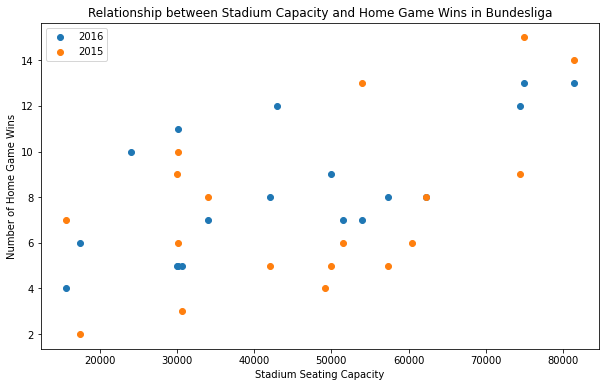

In [250]:
# Q5 Does stadium capacity have impact on number of home win games? 
# Both years 2015 and 2016 data is considered to answer this question
# Answer: Both years are showing a linear trend between stadium capacity and home game wins

teams_meta = spark.read.csv('Teams.csv',header=True,inferSchema=True)

bundesliga_matches_meta = bundesliga_matches \
.join(teams_meta, ((teams_meta['TeamName']==bundesliga_matches['Team']) \
                   & (teams_meta['Season']==bundesliga_matches['Season'])), 'inner') \
.drop(teams_meta['Season'])

bundesliga_matches_meta2016 = bundesliga_matches_meta.filter((col('Season') == '2016'))
bundesliga_matches_meta2015 = bundesliga_matches_meta.filter((col('Season') == '2015'))
bundesliga_matches_meta2014 = bundesliga_matches_meta.filter((col('Season') == '2014'))

df_bundesliga_matches_meta2016 = bundesliga_matches_meta2016.toPandas()
df_bundesliga_matches_meta2015 = bundesliga_matches_meta2015.toPandas()
df_bundesliga_matches_meta2014 = bundesliga_matches_meta2014.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.xlabel('Stadium Seating Capacity') 
plt.ylabel('Number of Home Game Wins')
plt.title("Relationship between Stadium Capacity and Home Game Wins in Bundesliga")
plt.scatter(df_bundesliga_matches_meta2016['StadiumCapacity'], df_bundesliga_matches_meta2016['HomeMatchesWon'],label='2016')
plt.scatter(df_bundesliga_matches_meta2015['StadiumCapacity'], df_bundesliga_matches_meta2015['HomeMatchesWon'],label='2015')

plt.legend()
plt.show()

### Question #6 Does domestic/foreign players count have any impact on total team points for Hannover?

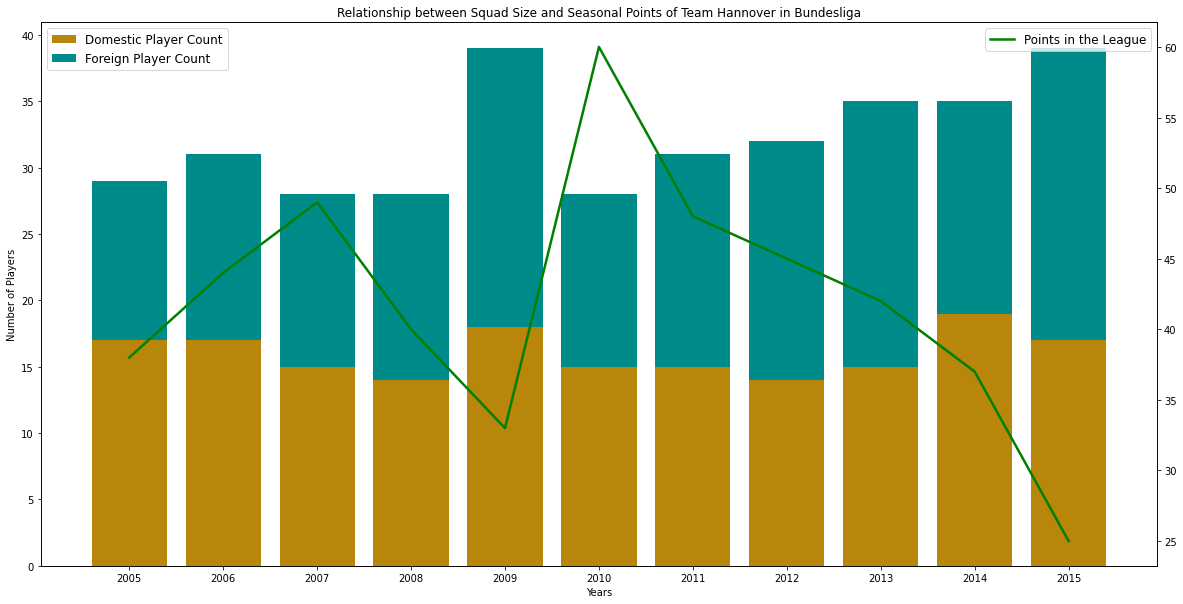

In [390]:
# Q6 Does domestic/foreign players count have any impact on total team points for Hannover? 
# Answer:there is no direct correlation between the player count or ratio of domestic/foreign players 
# on the performance of Hannover. However, from 2010 to 2015, team seems to be collecting lesser points
# in each season while number of player count gradually increases over the years. However, this observation cannot
# prove the hypothesis of correlation between these 2 factors.

import numpy as np

bundesliga_matches_meta_dortmund = bundesliga_matches_meta.filter((col('Team') == "Hannover")) \
.withColumn('DomesticPlayersHome', col('KaderHome')-col('ForeignPlayersHome')) \
.withColumn('Points', (col('HomeMatchesWon')+col('AwayMatchesWon'))*3 + (col('HomeMatchesTie')+col('AwayMatchesTie'))*1)\
.sort(col('Season').asc())


df_bundesliga_matches_meta_dortmund = bundesliga_matches_meta_dortmund.toPandas()

plt.figure(figsize=(20,10))
plt.xlabel('Years') 
plt.ylabel('Number of Players')
plt.title("Relationship between Squad Size and Seasonal Points of Team Hannover in Bundesliga")
plt.bar(df_bundesliga_matches_meta_dortmund['Season'], \
        df_bundesliga_matches_meta_dortmund['DomesticPlayersHome'], color='darkgoldenrod')
plt.bar(df_bundesliga_matches_meta_dortmund['Season'], \
        df_bundesliga_matches_meta_dortmund['ForeignPlayersHome'],\
       bottom=df_bundesliga_matches_meta_dortmund['DomesticPlayersHome'], color='darkcyan')

plt.legend(["Domestic Player Count", "Foreign Player Count"], fontsize='12')
plt.xticks(np.arange(2005, 2017, 1))

axes2 = plt.twinx()
axes2.plot(df_bundesliga_matches_meta_dortmund['Season'], df_bundesliga_matches_meta_dortmund['Points'],color='g', linewidth=2.5)
axes2.legend(['Points in the League'], fontsize='12')

plt.show()


### Question #7 What is the market trend of Bundesliga Division 1 and 2 between 2005 and 2016? 

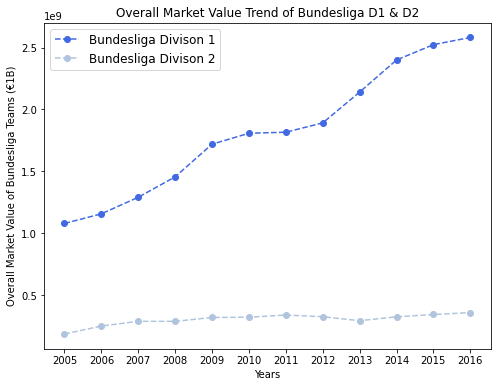

In [402]:
# What is the trend of Bundesliga D1 and D2 Team's Overall Market Value?
# Answer: Division 1 team's overall market value seems to be increasing over the years
# However, same cannot be said for Division 2 teams. In order for D2 teams to be profitable and gain market value
# its crucial that they need to present in Division 1

# Preparing the dataset for Bundesliga League 1
bundesliga_matches_marketval  = bundesliga_matches_meta

bundesliga_matches_marketval = bundesliga_matches_marketval.groupBy('Season')\
.agg(func.sum('OverallMarketValueHome').alias('OverallMarketValue'))\
.sort(col('Season').asc())

df_bundesliga_matches_marketval = bundesliga_matches_marketval.toPandas()

# Preparing the dataset for Bundesliga League 2 
bundesliga2 = df_matches2.filter((col('Div') == 'D2') & (col('Season') <= 2016))

bundesliga_home2 = bundesliga2.groupBy(['Season', 'HomeTeam']) \
    .agg(summation('HomeTeamGoals').alias('HomeTotalGoalScored'), 
        summation('AwayTeamGoals').alias('HomeTotalGoalConceded'), 
        summation('HomeTeamWin').alias('HomeMatchesWon'),
        summation('AwayTeamWin').alias('HomeMatchesLost'),
        summation('GameTie').alias('HomeMatchesTie'),
        summation(bundesliga2['HomeTeamWin'] + bundesliga2['AwayTeamWin'] + bundesliga2['GameTie']).alias('HomeMatchesPlayed'))

bundesliga_home2 = bundesliga_home2.withColumnRenamed('HomeTeam', 'Team')

bundesliga_away2 = bundesliga2.groupBy(['Season', 'AwayTeam']) \
    .agg(summation('AwayTeamGoals').alias('AwayTotalGoalScored'), 
        summation('HomeTeamGoals').alias('AwayTotalGoalConceded'), 
        summation('AwayTeamWin').alias('AwayMatchesWon'),
        summation('HomeTeamWin').alias('AwayMatchesLost'),
        summation('GameTie').alias('AwayMatchesTie'),
        summation(bundesliga2['HomeTeamWin'] + bundesliga2['AwayTeamWin'] + bundesliga2['GameTie']).alias('AwayMatchesPlayed'))

bundesliga_away2 = bundesliga_away2.withColumnRenamed('AwayTeam', 'Team')

bundesliga_matches2 = bundesliga_home2.join(bundesliga_away2, ['Season', 'Team'], 'inner')

bundesliga_matches_meta2 = bundesliga_matches2 \
.join(teams_meta, ((teams_meta['TeamName']==bundesliga_matches2['Team']) \
                   & (teams_meta['Season']==bundesliga_matches2['Season'])), 'inner') \
.drop(teams_meta['Season'])

bundesliga_matches_marketval2  = bundesliga_matches_meta2

bundesliga_matches_marketval2 = bundesliga_matches_marketval2.groupBy('Season')\
.agg(func.sum('OverallMarketValueHome').alias('OverallMarketValue'))\
.sort(col('Season').asc())

df_bundesliga_matches_marketval2 = bundesliga_matches_marketval2.toPandas()


plt.figure(figsize=(8,6))
plt.xlabel('Years') 
plt.ylabel('Overall Market Value of Bundesliga Teams (€1B)')
plt.title("Overall Market Value Trend of Bundesliga D1 & D2")
plt.xticks(np.arange(2005, 2017, 1))
plt.plot(df_bundesliga_matches_marketval['Season'], df_bundesliga_matches_marketval['OverallMarketValue'], '--o', color='royalblue')
plt.plot(df_bundesliga_matches_marketval2['Season'], df_bundesliga_matches_marketval2['OverallMarketValue'], '--o', color='lightsteelblue')
plt.legend(["Bundesliga Divison 1", "Bundesliga Divison 2"], fontsize='12')
plt.show()

### Stoping the Spark Session

In [3]:
spark.sparkContext.stop()
spark.stop()